# Sentiment Analysis Using Tensorflow GRU with Attention Layer

## Imports

In [8]:
import time
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.compat.v1.keras.layers import CuDNNGRU, Embedding, Dropout,Dense, Bidirectional, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop, Adamax , Adam

from attention.layers import AttentionLayer
import tensorflow as tf
from tensorflow.python.client import device_lib

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #This is for multiple print statements per cell

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/home/erolerten/anaconda3/envs/venv-tensorflow/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1752: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


## Confirm GPU processing available

In [9]:
value = tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)
print ('***If TF can access GPU: ***\n\n',value) # MUST RETURN True IF IT CAN!!

print()
value = tf.config.list_physical_devices('GPU')
print(value)

print()
print(device_lib.list_local_devices())

***If TF can access GPU: ***

 True

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9096194728344294963
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 18327640651255599946
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13041573470967801411
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1259942707
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5760480221772166120
physical_device_desc: "device: 0, name: GeForce MX150, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


## Getting data

In [10]:
df = pd.read_csv('consolidated_tweet_data-cleaned-stemmed-lemmatized.csv', sep='\t')
df

,sentiment,text
0,negative,oh no it fade away again
1,positive,bunnylak will kill me but i cant stop listen t...
2,negative,last day in cali partyin for the last time wit...
3,negative,is have a major soar throat
4,positive,my last day a 12 year old
...,...,...
1611536,negative,twisuz yeah and how did thi happen i wa updat ...
1611537,negative,smittygoali im sorri about your dog
1611538,negative,posipat im alreadi there i wish you were here
1611539,negative,is think in 12 hour ill be at the airport thi ...


In [11]:
# How much of Dataset to be used
frac = 0.5
# sample and shuffle the dataset according to the fraction choise in the line above
df = df.sample(frac=frac).reset_index(drop=True)
df

,sentiment,text
0,positive,joey_c lol sweet or should i say quotsharpquot
1,positive,fli to the philippin at the end of the month c...
2,positive,ive updat my canva and i have more to come ple...
3,negative,oh god lilac fest start with a march band my p...
4,positive,jdawg1958 thi is definit a wast of time
...,...,...
805765,positive,mrsmoothsofli chillin chillin
805766,negative,work orient amp cpr class ughh
805767,positive,oxgigglesxo lol what mr p got to do with you c...
805768,negative,nekuchu im bore too dont you have job for summer


## Tokenization for training

In [12]:
vocabulary_size = 10000

In [13]:
tokenizer = Tokenizer(num_words=vocabulary_size, split=" ", oov_token='<OOV>')
tokenizer.fit_on_texts(df['text'].values)

In [14]:
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 2767,
         633,   57,  378,  107,  146,    2,  129,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  612,    3,    4, 2053,   25,    4,  264,   13,    4,  371,
          49,  105,    3,   62,    7, 1440,  112,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  142,  313,    7, 8097,    8,    2,   18,   90,    3,   88,
         171,  429,    3,  524, 1635,    1,   51,    9],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  

## Model, Training and Testing

### Creating the model

In [15]:
model = Sequential()
model.add(Embedding(vocabulary_size, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(Bidirectional(CuDNNGRU(256, return_sequences=True)))
# model.add(Dropout(0.3))
# model.add(Bidirectional(CuDNNGRU(256, return_sequences=True)))
model.add(AttentionLayer(name='attention'))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid'))

In [16]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 41, 256)           2560000   
_________________________________________________________________
dropout (Dropout)            (None, 41, 256)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 41, 512)           789504    
_________________________________________________________________
attention (AttentionLayer)   (None, 512)               263168    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense (Dense)                (None, 2)                 1026      
Total params: 3,615,746
Trainable params: 3,614,722
Non-trainable params: 1,024
________________________________________

### Training the model

In [17]:
y = pd.get_dummies(df['sentiment']).values
[print(df['sentiment'][i], y[i]) for i in range(0,5)]

positive [0 1]
positive [0 1]
positive [0 1]
negative [1 0]
positive [0 1]


[None, None, None, None, None]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [19]:
batch_size = 32
epochs = 5
datetime = str(datetime.now())
csv_logger = tf.keras.callbacks.CSVLogger('training'+datetime+'.log')
start = time.time()
print("started at:")
print(start)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[csv_logger])
end = time.time()
elapsed = end - start
print(elapsed/60," minutes")

started at:
1586157221.392328
Train on 644616 samples
Epoch 1/5
644616/644616 - 870s - loss: 0.4365 - accuracy: 0.7978
Epoch 2/5
644616/644616 - 865s - loss: 0.3953 - accuracy: 0.8218
Epoch 3/5
644616/644616 - 871s - loss: 0.3752 - accuracy: 0.8334
Epoch 4/5
644616/644616 - 869s - loss: 0.3621 - accuracy: 0.8406
Epoch 5/5
644616/644616 - 865s - loss: 0.3532 - accuracy: 0.8453
72.33485383987427  minutes


Plotting training history

Text(0.5, 1.0, 'Model accuracy')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epoch')

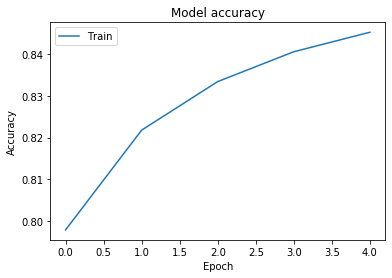

Text(0.5, 1.0, 'Model loss')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

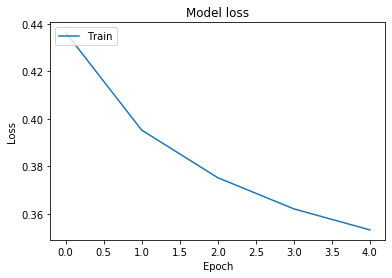

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


### Testing the model

In [21]:
predictions = model.predict(X_test)
[print(df['text'][i], predictions[i], y_test[i]) for i in range(0, 5)]

joey_c lol sweet or should i say quotsharpquot  [0.8544729  0.14512753] [1 0]
fli to the philippin at the end of the month cant wait to see my girlfriend again httpthephilippinesph  [0.7375846 0.2612919] [1 0]
ive updat my canva and i have more to come plea rememb to vote daili httptinyurlcomck88zb thank you  [0.04686708 0.95326346] [0 1]
oh god lilac fest start with a march band my poor head  [0.6605361  0.33934557] [0 1]
jdawg1958 thi is definit a wast of time  [0.6660254  0.33426186] [0 1]


[None, None, None, None, None]

In [22]:
accurate_prediction_count, inaccurate_prediction_count = 0, 0
for i, prediction in enumerate(predictions):
    if np.argmax(prediction)==np.argmax(y_test[i]):
        accurate_prediction_count += 1
    else:
        inaccurate_prediction_count += 1

total_predictions = accurate_prediction_count + inaccurate_prediction_count
print('Number of predictions: ', total_predictions)
print('Number of accurate predictions: ', accurate_prediction_count)
print('Number of false predictions: ', inaccurate_prediction_count)    
print('Accuracy: ', accurate_prediction_count/total_predictions)

Number of predictions:  161154
Number of accurate predictions:  132493
Number of false predictions:  28661
Accuracy:  0.8221514824329523


### Saving the trained model

name of the file

In [23]:
name = 'sentiment-analysis-trained-model'

In [37]:
from datetime import datetime
dateTimeObj = datetime.now()

In [39]:
date = str(dateTimeObj.date())
time = str(dateTimeObj.time())
timestamp = date+time
punctuation = ['-',':','.']
for sign in punctuation:
    timestamp = timestamp.replace(sign,'')
print(timestamp)

20200406114130582064


In [40]:
model.save(name+timestamp+'.h5')